# Genetic Algorithms

Import needed libraries

In [16]:
from pygad import GA

Set up dictionaries to reference values in fitness function

In [17]:
room_capacities = {
    "Slater 003": 45,
    "Roman 216": 30,
    "Loft 206": 75,
    "Roman 201": 50,
    "Loft 310": 108,
    "Beach 201": 60,
    "Beach 301": 75,
    "Logos 325": 450,
    "Frank 119": 60,
}

preferred_facilitators = {
    "SLA100A": ["Glen", "Lock", "Banks", "Zeldin"],
    "SLA100B": ["Glen", "Lock", "Banks", "Zeldin"],
    "SLA191A": ["Glen", "Lock", "Banks", "Zeldin"],
    "SLA191B": ["Glen", "Lock", "Banks", "Zeldin"],
    "SLA201": ["Glen", "Banks", "Zeldin", "Shaw"],
    "SLA291": ["Lock", "Banks", "Zeldin", "Singer"],
    "SLA303": ["Glen", "Zeldin", "Banks"],
    "SLA304": ["Glen", "Banks", "Tyler"],
    "SLA394": ["Tyler", "Singer"],
    "SLA449": ["Tyler", "Singer", "Shaw"],
    "SLA451": ["Tyler", "Singer", "Shaw"],
}

other_facilitators = {
    "SLA100A": ["Numen", "Richards"],
    "SLA100B": ["Numen", "Richards"],
    "SLA191A": ["Numen", "Richards"],
    "SLA191B": ["Numen", "Richards"],
    "SLA201": ["Numen", "Richards", "Singer"],
    "SLA291": ["Numen", "Richards", "Shaw", "Tyler"],
    "SLA303": ["Numen", "Singer", "Shaw"],
    "SLA304": ["Numen", "Singer", "Shaw", "Richards", "Uther", "Zeldin"],
    "SLA394": ["Richards", "Zeldin"],
    "SLA449": ["Zeldin", "Uther"],
    "SLA451": ["Zeldin", "Uther", "Richards", "Banks"],
}

expected_enrollment = {
    "SLA100A": 50,
    "SLA100B": 50,
    "SLA191A": 50,
    "SLA191B": 50,
    "SLA201": 50,
    "SLA291": 50,
    "SLA303": 60,
    "SLA304": 25,
    "SLA394": 20,
    "SLA449": 60,
    "SLA451": 100,
}

Set up gene spaces. Each class is represented by 3 genes, one for location, time, and facilitator each. These are repeated in order for the number of classes. Each gene will be an integer that references the index of its corresponding gene space list.

In [18]:
class_order = list(expected_enrollment.keys())
class_order.sort()

time_gene_space = [
    10,
    11,
    12,
    13,
    14,
    15,
]

facilitator_gene_space = [
    "Lock",
    "Glen",
    "Banks",
    "Richards",
    "Shaw",
    "Singer",
    "Uther",
    "Tyler",
    "Numen",
    "Zeldin",
]

room_gene_space = [room for room in room_capacities.keys()]

num_genes = (
    len(expected_enrollment)
)

gene_space = [
    list(range(len(room_gene_space))),
    list(range(len(time_gene_space))),
    list(range(len(facilitator_gene_space))),
]

gene_space = [space for _ in range(num_genes) for space in gene_space]

## Fitness Class

This class is really just a collection of static methods that all help with the calculation of the fitness functions. No instantiation is needed. The chromosone_to_dict function uses those reference gene spaces to decode the integers of each gene into a dictionary for each activity. Those dictionaries are stored in one larger dictionary with the key being the activity and the value being the genes for that activity. There is also print_chromosone which will nicely print the given chromosone. Most importantly, there is the actual fitness function. It's pretty much just the sum of a few helper functions that break down parts of the fitness function. There are also the helper functions, they either calculate aspects of the whole chromosone like facilitator load, or aspects of a single class like room capacity being enough.

In [19]:
class Fitness:
    @staticmethod
    def chromosone_to_dict(chromosone) -> dict:
        num_genes = len(chromosone) // 3
        chromosones = chromosone.reshape(num_genes, 3)
        chromosone_dict = {}
        for index, gene in enumerate(chromosones):
            room = room_gene_space[gene[0]]
            time = time_gene_space[gene[1]]
            facilitator = facilitator_gene_space[gene[2]]
            chromosone_dict[class_order[index]] = {
                "room": room,
                "time": time,
                "facilitator": facilitator,
            }
        return chromosone_dict

    @staticmethod
    def print_chromosone(chromosone) -> None:
        for activity, details in chromosone.items():
            print(f"{activity}:\n\tRoom: {details['room']}\n\tTime: {details['time']}\n\tFacilitator: {details['facilitator']}")
            
    @staticmethod
    def fitness_func(ga_instance, chromosone, solution_idx) -> float:
        fitness = 0
        
        chromosone = Fitness.chromosone_to_dict(chromosone)

        fitness += Fitness.get_facilitator_load_fitness(chromosone)
        fitness += Fitness.get_activity_specific_fitness(chromosone)
        
        for activity, genes in chromosone.items():
            fitness += Fitness.get_room_fitness(activity, genes)
            fitness += Fitness.get_facilitator_preference_fitness(activity, genes)

        return fitness
    
    @staticmethod
    def get_room_fitness(activity, genes) -> float:
        enrollment = expected_enrollment[activity]
        room_capacity = room_capacities[genes["room"]]

        if enrollment > room_capacity:
            return -0.5
        elif enrollment * 6 < room_capacity:
            return -0.4
        elif enrollment * 3 < room_capacity:
            return -0.2
        else:
            return 0.3

    @staticmethod
    def get_facilitator_preference_fitness(activity, genes) -> float:
        facilitator = genes["facilitator"]
        if facilitator in preferred_facilitators[activity]:
            return 0.5
        elif facilitator in other_facilitators[activity]:
            return 0.2
        else:
            return -0.1

    @staticmethod
    def get_same_room_penalty(chromosones):
        room_times = [(gene["room"], gene["time"]) for gene in chromosones.values()]
        num_conflicts = len(set([room_time for room_time in room_times if room_times.count(room_time) >= 2]))
        return -0.5 * num_conflicts

    @staticmethod
    def get_facilitator_load_fitness(chromosones):
        fitness_modifier = 0
        facilitator_times = {facilitator: {} for facilitator in facilitator_gene_space}

        for activity, details in chromosones.items():
            facilitator = details["facilitator"]
            time = details["time"]
            room = details["room"]

            if time in facilitator_times[facilitator]:
                facilitator_times[facilitator][time].append(room)
            else:
                facilitator_times[facilitator][time] = [room]

        for facilitator, times in facilitator_times.items():
            for time, rooms in times.items():
                if time + 1 in times.keys():
                    class_1_in_rooms = any([room for room in rooms if room in ["Roman 216", "Roman 201", "Beach 201", "Beach 301"]])
                    class_2_in_rooms = any([room for room in times[time+1] if room in ["Roman 216", "Roman 201", "Beach 201", "Beach 301"]])
                    if class_1_in_rooms or class_2_in_rooms:
                        if not (class_1_in_rooms and class_2_in_rooms):
                            fitness_modifier -= 0.4
                        else:
                            fitness_modifier += 0.5
                    else:
                        fitness_modifier += 0.5
                if len(rooms) == 1:
                    fitness_modifier += 0.2
                elif len(rooms) > 1:
                    fitness_modifier -= 0.2

            num_classes = len(times)
            if num_classes > 4:
                fitness_modifier -= 0.5
            elif num_classes in [1, 2]:
                if facilitator != "Tyler":
                    fitness_modifier -= 0.4
        return fitness_modifier

    @staticmethod
    def get_activity_specific_fitness(chromosones):
        fitness_modifier = 0
        
        if abs(chromosones["SLA100A"]["time"] - chromosones["SLA100B"]["time"]) >= 4:
            fitness_modifier += 0.5
        elif chromosones["SLA100A"]["time"] == chromosones["SLA100B"]["time"]:
            fitness_modifier -= 0.5

        if abs(chromosones["SLA191A"]["time"] - chromosones["SLA191B"]["time"]) >= 4:
            fitness_modifier += 0.5
        elif chromosones["SLA191A"]["time"] == chromosones["SLA191B"]["time"]:
            fitness_modifier -= 0.5

        sla100_instances = [chromosones["SLA100A"], chromosones["SLA100B"]]
        sla191_instances = [chromosones["SLA191A"], chromosones["SLA191B"]]

        for sla100 in sla100_instances:
            for sla191 in sla191_instances:
                if sla100["time"] == sla191["time"]:
                    fitness_modifier -= 0.25
                elif abs(sla100["time"] - sla191["time"]) == 1:
                    sla100_in_rooms = sla100["room"] in ["Roman 216", "Roman 201", "Beach 201", "Beach 301"]
                    sla191_in_rooms = sla191["room"] in ["Roman 216", "Roman 201", "Beach 201", "Beach 301"]
                    if sla100_in_rooms or sla191_in_rooms:
                        if not (sla100_in_rooms and sla191_in_rooms):
                            fitness_modifier -= 0.4
                        else:
                            fitness_modifier += 0.5
                    else:
                        fitness_modifier += 0.5
                elif abs(sla100["time"] - sla191["time"]) == 2:
                    fitness_modifier += 0.25
        return fitness_modifier
    

## PyGAD class

This is the library I used to build the genetic algorithm. There are some hooks that 

In [20]:
def on_stop(ga_instance, fit):
    print(f"\nHighest Fitness: {ga_instance.best_solution()[1]:.1f}\n")
    Fitness.print_chromosone(Fitness.chromosone_to_dict(ga_instance.best_solution()[0]))
    ga_instance.plot_fitness()

def on_gen(ga_instance):
    ga_instance.mutation_probability /= 1.25
    
algorithm = GA(
    num_genes=num_genes*3,
    gene_type=int,
    gene_space=gene_space,
    fitness_func=Fitness.fitness_func,
    num_generations=100,
    num_parents_mating=500,
    sol_per_pop=1000,
    crossover_type="two_points",
    mutation_probability=0.01,
    on_generation=on_gen,
    on_stop=on_stop
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Highest Fitness: 17.0

SLA100A:
	Room: Beach 201
	Time: 14
	Facilitator: Lock
SLA100B:
	Room: Frank 119
	Time: 10
	Facilitator: Zeldin
SLA191A:
	Room: Loft 206
	Time: 11
	Facilitator: Zeldin
SLA191B:
	Room: Beach 301
	Time: 15
	Facilitator: Lock
SLA201:
	Room: Frank 119
	Time: 13
	Facilitator: Zeldin
SLA291:
	Room: Roman 201
	Time: 13
	Facilitator: Lock
SLA303:
	Room: Loft 206
	Time: 12
	Facilitator: Zeldin
SLA304:
	Room: Slater 003
	Time: 10
	Facilitator: Tyler
SLA394:
	Room: Frank 119
	Time: 13
	Facilitator: Tyler
SLA449:
	Room: Loft 310
	Time: 12
	Facilitator: Tyler
SLA451:
	Room: Loft 310
	Time: 11
	Facilitator: Tyler


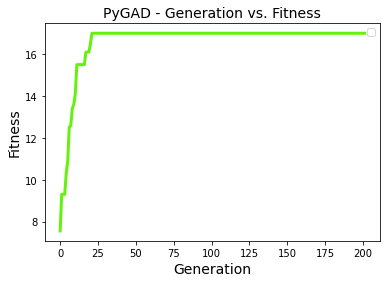

In [22]:
algorithm.run()